In [1]:
using Pkg
Pkg.activate("..")
#Pkg.develop(["Equilibrium", "IMAS"])
using Revise
using FUSE
using FUSE.IMAS

  Activating environment at `~/.julia/dev/FUSE/Project.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1317


In [100]:
ϵ = 0.32
κ = 1.7
δ = 0.33
R0 = 6.2
B0 = 5.3
ip = 15.E6
beta_n = 3.0

resolution = 33

eq0=IMAS.equilibrium()
FUSE.init(eq0, 0.0; B0, R0, ϵ, δ, κ, beta_n, ip, x_point=false)

eqactor = FUSE.SolovevEquilibriumActor(eq0, 0.0, alpha=1, qstar=1.5)
#@time FUSE.step(eqactor)
print(eqactor.S)

eq1 = FUSE.finalize(eqactor, resolution, (R0*(1-ϵ*2),R0*(1+ϵ*2)), (-R0*ϵ*κ*2,R0*ϵ*κ*2))

eqt = eq1.time_slice[1];

SolovevEquilibrium
  B0 = 5.3 [T]
  R0 = 6.2 [m]
  ϵ  = 0.32
  δ  = 0.33
  κ  = 1.7
  α  = 1.0
  q⋆ = 1.5
  βp = 0.0
  βt = 0.0
  σ  = 1
  diverted  = true
  xpoint  = (5.479808, -3.7100800000000005)
  symmetric = false

LoadError: Could not trace a closed flux surface at ψₙ of 1.0

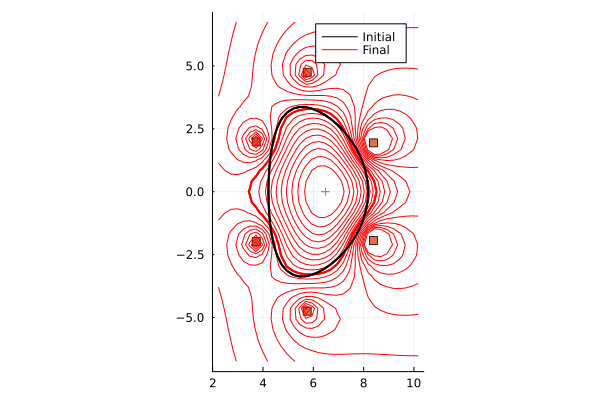

 * Status: success

 * Candidate solution
    Final objective value:     8.142361e-02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit 30)
    Iterations:    679
    f(x) calls:    1212



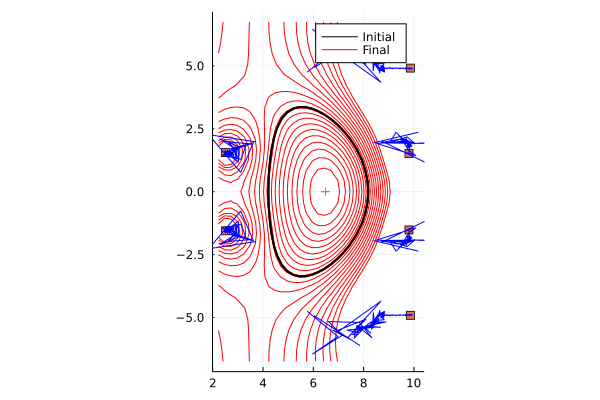

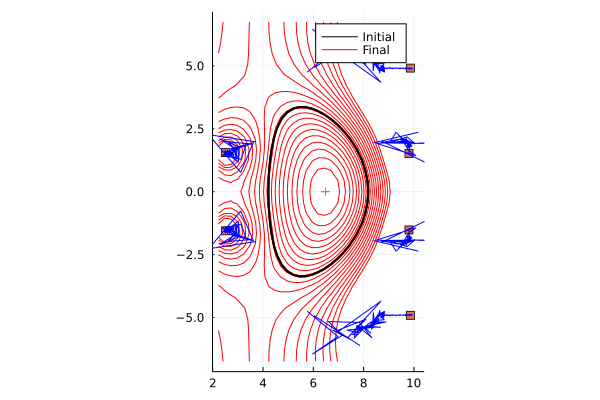

In [98]:
using Plots
import Plots:plot

function Plots.plot!(pf_active::IMAS.pf_active)
    Plots.plot!([c.element[1].geometry.rectangle.r for c in pf_active.coil],[c.element[1].geometry.rectangle.z for c in pf_active.coil],markershape=:rect,lw=0,label="",aspect=:equal)
end

function Plots.plot!(pfactor::PFcoilsOptActor)
    # plot mask
    rmask=pfactor.rmask
    zmask=pfactor.zmask
    dst=pfactor.mask_log_interpolant(zmask,rmask)
    plt=plot([NaN],[NaN],xlim=[rmask[1],rmask[end]],ylim=[zmask[1],zmask[end]],aspect_ratio=:equal,label="")
    #Plots.heatmap(rmask,zmask,dst,xlim=[rmask[1],rmask[end]],ylim=[zmask[1],zmask[end]], aspect_ratio=:equal,colorbar=false)
    
    # plot pf_active coils
    Plots.plot!(pfactor.pf_active)
    plot!(pfactor.eq_in.time_slice[1];label="Initial",lcfs=true, color=:black)
    plot!(pfactor.eq_out.time_slice[1];label="Final",color=:red)
    plot!(pfactor.eq_in.time_slice[1];label="",lcfs=true, color=:black)
    
    if :coils in keys(pfactor.trace)
        for c in 1:length(pfactor.trace[:coils][1])
            if c==1
                fplot=plot!
            elseif c==length(pfactor.trace[:coils][1])
                fplot(args...;kw...)=display(plot!(args...;kw...))
            else
                fplot=plot!
            end
            fplot([FUSE.no_Dual(k[c][1]) for k in pfactor.trace[:coils]],[FUSE.no_Dual(k[c][2]) for k in pfactor.trace[:coils]],label="",color=:blue, lw=1)
        end
    end
    return plt
end

function Plots.plot!(eqt::IMAS.equilibrium__time_slice, args...; lcfs=false, kw...)
    if lcfs
        psi_levels=[eqt.global_quantities.psi_boundary,eqt.global_quantities.psi_boundary]
        psi_levels_out=[]
    else
        psi_levels=range(eqt.global_quantities.psi_axis,eqt.global_quantities.psi_boundary,length=11)
        psi_levels_out=(psi_levels[end]-psi_levels[1]).*collect(range(0,1,length=11)).+psi_levels[end]
    end

    setdefault(args,:lw,get(args,:lw,1))
    args_lcfs=copy.deepcopy(args_lcfs)
    args_lcfs[:kw]+=1

    k=1
    primary=true
    for psi_level in vcat(psi_levels[2:end],psi_levels_out)
        for (pr,pz) in IMAS.flux_surface(eqt, psi_level, false)
            primary = k==1 ? true : false
            if psi_level == eqt.global_quantities.psi_boundary
                Plots.plot!(pr, pz, args...; primary=primary, kw...)
            else
                Plots.plot!(pr, pz, args...,; primary=primary,kw...)
            end
            k+=1
        end
    end
    Plots.plot!([eqt.global_quantities.magnetic_axis.r], [eqt.global_quantities.magnetic_axis.z],args...;marker=:cross, primary=primary,kw...)
end

#===============#

pfoptactor=PFcoilsOptActor(eq1,0.0, 6);

display(plot!(pfoptactor))

step(pfoptactor,verbose=true)

display(plot!(pfoptactor))

In [4]:
using IMAS
for expr in keys(IMAS.expressions)
    getfield(u2f(p2i(i2p(expr)[1:end-1])), i2p(expr)[end])
end

LoadError: TypeError: in getfield, expected Symbol, got a value of type String

In [5]:
using Pkg
Pkg.add("LinearAlgebra")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/dev/FUSE/Project.toml`
  No Changes to `~/.julia/dev/FUSE/Manifest.toml`
